In [1]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

from model import ZeroTTT
from database import DataBase

In [2]:
def test_loss(model):
    model.brain.eval()
    total_p_loss = 0.0
    total_v_loss = 0.0
    for s, p, v in test_set:
        batch_sts, batch_pls, batch_vls = database.prepare_batches(batch_size=batch_size, from_memory_paths=(s, p, v))
        for b_nr in range(len(batch_sts)):
            batch_st, batch_pl, batch_vl = batch_sts[b_nr], batch_pls[b_nr], batch_vls[b_nr]
            
            batch_pl = torch.from_numpy(batch_pl).to(model.device)
            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_policy=False)
            val = val.flatten()

            p_loss = model.policy_loss(prob, batch_pl)
            v_loss = model.value_loss(val, batch_vl)
        
            total_p_loss += p_loss.item()
            total_v_loss += v_loss.item()
    return total_p_loss/(len(batch_sts)*len(test_set)), total_v_loss/(len(batch_sts)*len(test_set))

In [3]:
def train_model(model_name, model_opt_state, lr, weight_decay, epochs, batch_size, ind1, ind2, model_num, index):
    args = {
        "lr": lr,
        "weight_decay": weight_decay,
        "board_len": 10
    }
    
    model = ZeroTTT(brain_path=model_name, opt_path=model_opt_state, args=args)
    
    train_policy_losses = []
    train_value_losses = []
    test_policy_losses = []
    test_value_losses = []
    
    db_args = {
        "max_len": (ind2-ind1)*10000,
        "augmentations": []
    }
           
    db = DataBase(db_args)
    for num in range(ind1, ind2):
        db.load_data("/storage/replay_buffer", num) 
                            
    for e in range(epochs):
        model.brain.train()
        
        batch_sts, batch_pls, batch_vls = db.prepare_batches(batch_size)
         
        for b_nr in range(len(batch_sts)):
            
            model.optimizer.zero_grad()
            batch_st, batch_pl, batch_vl = batch_sts[b_nr], batch_pls[b_nr], batch_vls[b_nr]
            
            batch_pl = torch.from_numpy(batch_pl).to(model.device)
            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_output=False)
            val = val.flatten()

            p_loss = model.policy_loss(prob, batch_pl)
            # p_loss /= 4.0
            v_loss = model.value_loss(val, batch_vl)

            train_policy_losses.append(p_loss.item())
            train_value_losses.append(v_loss.item())

            loss = p_loss + v_loss
            loss.backward()

            model.optimizer.step()
    
        # Loss on test set:
        # test_epoch_policy_loss, test_epoch_value_loss = test_loss(model)
        print(f"Epoch #{e} train policy loss: {sum(train_policy_losses)/len(train_policy_losses)} | train value loss: {sum(train_value_losses)/len(train_value_losses)}")
        # print(f"Test policy loss: {test_epoch_policy_loss} | Test value loss: {test_epoch_value_loss}")
        # test_policy_losses.append(test_epoch_policy_loss)
        # test_value_losses.append(test_epoch_value_loss)
        # Checkpoint:
        model.save_brain(f"trained_model_{model_num}_{index}", f"trained_opt_state_{model_num}_{index}")
                    
        plt.plot(train_policy_losses)
        # plt.plot(test_policy_losses)
        plt.show()
                    
        plt.plot(train_value_losses)
        # plt.plot(test_policy_losses)
        plt.show()

In [4]:
def train_on_swapped_value(model_name, model_opt_state, lr, weight_decay, epochs, batch_size, ind1, ind2, model_num, index):
    args = {
        "lr": lr,
        "weight_decay": weight_decay,
        "board_len": 10
    }
    
    model = ZeroTTT(brain_path=model_name, opt_path=model_opt_state, args=args)

    
    train_value_losses = []
    test_value_losses = []
    
    db_args = {
        "max_len": (ind2-ind1)*10000,
        "augmentations": []
    }
           
    db = DataBase(db_args)

           
    for num in range(ind1, ind2):
        db.load_data("/storage/replay_buffer", num) 
                            
    for e in range(epochs):
        model.brain.train()
        
        batch_sts, batch_pls, batch_vls = db.prepare_batches(batch_size)
         
        for b_nr in range(len(batch_sts)):
                        
            model.optimizer.zero_grad()
            batch_st, batch_vl = batch_sts[b_nr], batch_vls[b_nr]
            
            for i in range(len(batch_st)):
                batch_st[i][[0, 1]] = batch_st[i][[1, 0]]
                
            batch_vl *= -1.0

            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_output=False)
            val = val.flatten()

            v_loss = model.value_loss(val, batch_vl)

            train_value_losses.append(v_loss.item())

            loss = v_loss
            loss.backward()

            model.optimizer.step()
    
        print(f"Epoch #{e} train value loss: {sum(train_value_losses)/len(train_value_losses)}")
        # Checkpoint:
        model.save_brain(f"trained_model_{model_num}_{index}", f"trained_opt_state_{model_num}_{index}")
        
        plt.plot(train_value_losses)
        plt.show()

Loading brain...
Epoch #0 train policy loss: 3.442760134079544 | train value loss: 0.8038696647550465
Saving brain...


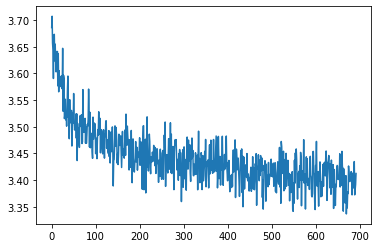

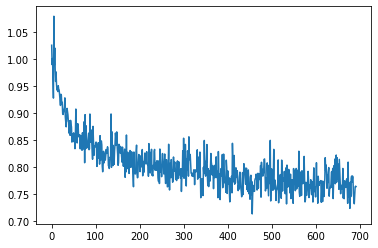

In [5]:
train_model("trained_model_2", "trained_opt_state_2", 3e-4, 1e-4, 1, 1500, 300, 404, 3, 0)